<a href="https://colab.research.google.com/github/BarNahmias/stars_tracker/blob/main/Start_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **star tracker**

**Algorithm description:**

An algorithm for solving the problem of matching the stars between two images and finding the transition matrix between them

**Step A:** Image processing, noise filtering and finding the coordinates of the constellation in the two images

**Step B:** Finding a group **T1**,**T2** triangles whose vertices are the stars for each image.

**Step C:**
Finding the group of similar triangles from **T1**,**T2** according to sides.

**Step D:** Performing a linear transformation between two similar triangles **t1**,**t2**, in 6 points
and finding the common stars

**Step E:** Repeat step **D** until finding the best transformation


https://benedikt-bitterli.me/astro/




In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)


#enter your foldername assignments/assignement1
FOLDERNAME = 'Vision'
              
assert FOLDERNAME is not None , "[!] Enter the foldername"

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
     

Mounted at /content/drive


**Extracting coordinates of stars from an image**

In [ ]:
import cv2
import numpy as np
import os

In [ ]:
"""
The function receives an image and performs noise filtering and image processing
"""
def load_image(image):
    # Load image
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # Apply binary thresholding to convert to black and white
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    # define structuring element for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    # perform morphological opening to remove small spots
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

"""
 Display image
"""
def draw_image(image, group_pts):
    # Make a copy of the input image so we don't modify the original
    img = image.copy()

    box_size = 15

    # Draw group points in blue
    for pt in group_pts:
        # cv2.circle(img, (int(pt.pt[0]), int(pt.pt[1])), 3, (255, 0, 0), -1)
        cv2.rectangle(img, (int(pt.pt[0] - 10), int(pt.pt[1] - box_size)),
                      (int(pt.pt[0] + box_size), int(pt.pt[1] + box_size)), (0, 255, 0), 2)
    image_with_lines_resized = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)

    # Save image to "match photo" directory with filename
    match_photo_dir = "match photo"
    os.makedirs(match_photo_dir, exist_ok=True)  # create directory if it doesn't exist
    filepath = os.path.join(match_photo_dir, "match.jpg")
    cv2.imwrite(filepath, image_with_lines_resized)
    return image_with_lines_resized




Processes the image, finds stars and paints them white

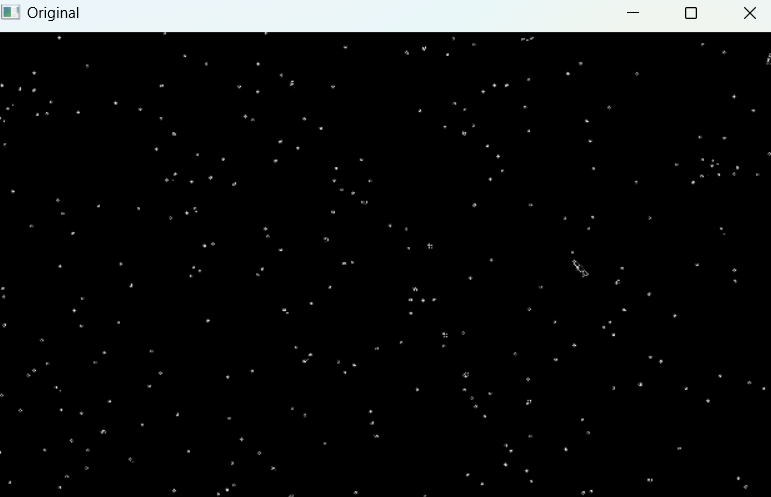

In [ ]:
def main():
    # Load the image and convert to grayscale
    image_path='ST_db2.png'
    img ,keypoints = process_image('/content/drive/MyDrive/Colab Notebooks/ST_db1.png')
    cv2.imshow('Original', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    for kp in keypoints:
        x,y = kp.pt
        r=kp.size
        b=kp.response
        print(f'x: ',{x}, f'y: ',{y}, f'r: ',{r}, f'b: ',{b})

x:  {16.564708709716797} y:  {259.44903564453125} r:  {1.738549828529358} b:  {0.022378353402018547}
x:  {22.376008987426758} y:  {229.9370880126953} r:  {1.7459964752197266} b:  {0.024086248129606247}
x:  {22.512048721313477} y:  {1118.5120849609375} r:  {1.7228845357894897} b:  {0.02494100295007229}
x:  {27.68964958190918} y:  {967.1912841796875} r:  {1.7283573150634766} b:  {0.00801833439618349}
x:  {28.512048721313477} y:  {141.51205444335938} r:  {1.7228845357894897} b:  {0.02494100295007229}
x:  {29.630290985107422} y:  {681.8135375976562} r:  {1.7254610061645508} b:  {0.006191962398588657}
x:  {33.51205062866211} y:  {704.5120239257812} r:  {1.7228845357894897} b:  {0.02494100295007229}
x:  {34.69218063354492} y:  {781.6028442382812} r:  {1.6924593448638916} b:  {0.008472414687275887}
x:  {36.51205062866211} y:  {300.5120544433594} r:  {1.7228845357894897} b:  {0.02494100295007229}
x:  {44.44902038574219} y:  {203.56471252441406} r:  {1.7385412454605103} b:  {0.02237836644053459}
x:  {49.5647087097168} y:  {1198.448974609375} r:  {1.738549828529358} b:  {0.022378353402018547}
x:  {56.69084930419922} y:  {424.305908203125} r:  {1.7300567626953125} b:  {0.0080299973487854}
x:  {75.69218444824219} y:  {152.60281372070312} r:  {1.6924593448638916} b:  {0.008472414687275887

# **step B - find triangels**

In [ ]:
"""
The function receives an image and performs noise filtering and image processing
"""
def load_image(image):
    # Load image
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # Apply binary thresholding to convert to black and white
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    # define structuring element for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    # perform morphological opening to remove small spots
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

"""
The function receives a processed image using the load_image function.
Outputs coordinates of stars in SIFT means.
 Creates patterns of triangles using three stars
"""
def create_triangle(image):
    img = cv2.imread(image)
    filtered_img = load_image(image)

    #The cv2.SIFT_create() function creates a SIFT object that can be used to detect keypoints
    # and extract descriptors from images using the SIFT algorithm.
    # The sigma parameter sets the scale of the difference of Gaussians used to detect keypoints

    sift = cv2.SIFT_create(sigma=0.9)
    kp = sift.detect(filtered_img, None)
    # sort the stars by response
    kp_filter = sorted(kp, key=lambda x: x.response, reverse=True)

    # Get keypoints coordinates as a NumPy array
    pts = np.array([k.pt for k in kp_filter[:]], dtype=np.float32)

    # Compute Delaunay triangulation of the keypoints
    tri = cv2.Subdiv2D((0, 0, img.shape[1], img.shape[0]))
    tri.insert(pts)
    triangle_list = tri.getTriangleList()
    return triangle_list, kp, img


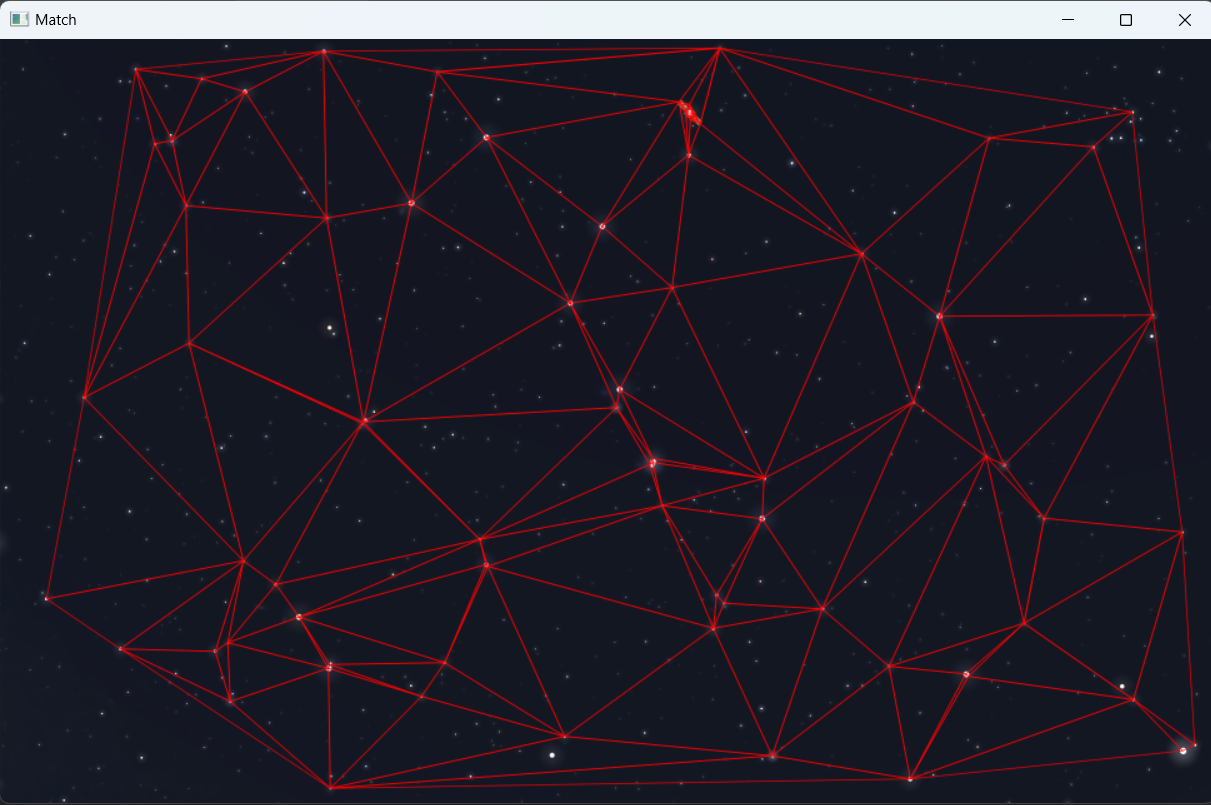

## **Star tracker code**

In [2]:
import random

import cv2
import numpy as np
import os
"""
https://benedikt-bitterli.me/astro/
"""


"""
The function receives an image and performs noise filtering and image processing
"""
def load_image(image):
    # Load image
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    # Apply binary thresholding to convert to black and white
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    # define structuring element for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    # perform morphological opening to remove small spots
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

"""
The function receives a processed image using the load_image function.
Outputs coordinates of stars in SIFT means.
 Creates patterns of triangles using three stars
"""
def create_triangle(image,sigma):
    img = cv2.imread(image)
    filtered_img = load_image(image)

    #The cv2.SIFT_create() function creates a SIFT object that can be used to detect keypoints
    # and extract descriptors from images using the SIFT algorithm.
    # The sigma parameter sets the scale of the difference of Gaussians used to detect keypoints

    sift = cv2.SIFT_create(sigma)
    kp = sift.detect(filtered_img, None)
    # sort the stars by response
    kp_filter = sorted(kp, key=lambda x: x.size, reverse=True)

    # Get keypoints coordinates as a NumPy array
    pts = np.array([k.pt for k in kp[:]], dtype=np.float32)

    # Compute Delaunay triangulation of the keypoints
    tri = cv2.Subdiv2D((0, 0, img.shape[1], img.shape[0]))
    tri.insert(pts)
    triangle_list = tri.getTriangleList()
    return triangle_list, kp, img

"""
The function receives a list of triangles
calculates their angles and returns a dictionary.
Key=angles , value=vertices
"""
def angle(triangle_list):
    # Create empty dictionary to store triangles by angles
    triangle_dict = {}
    # Loop through each triangle in the list
    for i in range(triangle_list.shape[0]):
        angle=[]
        # Get vertices of current triangle
        tri_pts = triangle_list[i].reshape(3, 2)

        # Get edges of triangle
        a = np.linalg.norm(tri_pts[0] - tri_pts[1])
        b = np.linalg.norm(tri_pts[1] - tri_pts[2])
        c = np.linalg.norm(tri_pts[2] - tri_pts[0])

        # Calculate angles using law of cosines
        alpha = np.degrees(np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c)))
        beta = np.degrees(np.arccos((c ** 2 + a ** 2 - b ** 2) / (2 * c * a)))
        gamma = np.degrees(np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b)))
        angle.append(round(alpha,0))
        angle.append(round(beta,0))
        angle.append(round(gamma,0))

        # Add triangle to dictionary using angles as key
        triangle_dict[tuple(angle)] = tri_pts
    return triangle_dict

"""
Get two dictionaries of triangle vertices and its angles
returns the list of similar
"""
def get_shared_angle(map1, map2):
    common_keys = set(map1.keys()) & set(map2.keys())
    shared_vertices = []
    for key in common_keys:
        triangle1 = map1[key]
        triangle2 = map2[key]
        shared_vertices.append((triangle1,triangle2))
    return shared_vertices

"""
 This function takes in two triangles, triangle1 and triangle2, and a set of points points.
 It extracts the (x, y) coordinates from the cv2.KeyPoint objects in points, creates a transformation matrix using cv2.getAffineTransform(),
 applies this transformation matrix to the points using cv2.transform(), converts the transformed points back to cv2.KeyPoint objects,
 and returns these transformed cv2.KeyPoint objects.
"""

def transform_points(triangle1, triangle2, points):
    # Extract (x, y) coordinates from cv2.KeyPoint objects
    points = [(kp.pt[0], kp.pt[1]) for kp in points]

    # Create transformation matrix
    M = cv2.getAffineTransform(triangle1, triangle2)

    # Apply transformation to points
    transformed_points = cv2.transform(np.array([points], dtype='float32'), M)
    transformed_points = transformed_points[0].tolist()

    # Convert back to cv2.KeyPoint objects
    transformed_kps = [cv2.KeyPoint(x, y, 1) for (x, y) in transformed_points]

    return transformed_kps

"""
This function find_shared_keypoints takes two lists of keypoints (keypoints1 and keypoints2)
and a delta_range as input,
and returns a list of keypoints that are close to each other within the specified delta_range
"""
def find_shared_keypoints(keypoints1, keypoints2, delta_range):
    shared_keypoints = []
    for kp1 in keypoints1:
        for kp2 in keypoints2:
            delta = np.sqrt((kp1.pt[0] - kp2.pt[0]) ** 2 + (kp1.pt[1] - kp2.pt[1]) ** 2)
            if delta <= delta_range:
                shared_keypoints.append(kp1)
                break
    return shared_keypoints

"""
The function goes over all similar triangles and performs a transformation.
Returns the transformation that gives the most common starsdef"
"""
def best_tra_transform(similar_triangle, points1,points2,delta):
    transform = []
    original = []
    shared_keypoint = []
    max = 500000
    if(max>len(similar_triangle)):
        max =len(similar_triangle)
    for i in range(max):
        curr_transform =transform_points(similar_triangle[i][0],similar_triangle[i][1],points1)
        curr_shared_keypoints =find_shared_keypoints(curr_transform,points2,delta)
        if len(curr_shared_keypoints) > len(shared_keypoint):
            shared_keypoint = curr_shared_keypoints
            transform = curr_transform
            # find the original shared keypoint from point1 (Reverse transformation)
            curr_original = transform_points(similar_triangle[i][1], similar_triangle[i][0], shared_keypoint)
            curr_shared_original = find_shared_keypoints(curr_original,points1,delta)
            original = curr_shared_original

    return shared_keypoint, transform, original

"""
The draw_keypoints_triangle function takes an image, a triangle, 
and a list of keypoints, and draws the triangle and the keypoints on the image
"""
def draw_keypoints_triangle(image,triangle,keypoints):
    triangle = np.array(triangle)
    # Draw the triangle on the image
    # img_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    img_combined= cv2.drawContours(image, [triangle.astype(int)], 0, (0, 0, 255), 2)
    image_with_lines_resized = cv2.resize(img_combined, (0, 0), fx=0.30, fy=0.30)

    return image_with_lines_resized

"""
 Display image
"""
def draw_image(image, group_pts):
    # Make a copy of the input image so we don't modify the original
    img = image.copy()

    box_size = 15

    # Draw group points in blue
    for pt in group_pts:
        # cv2.circle(img, (int(pt.pt[0]), int(pt.pt[1])), 3, (255, 0, 0), -1)
        cv2.rectangle(img, (int(pt.pt[0] - 10), int(pt.pt[1] - box_size)),
                      (int(pt.pt[0] + box_size), int(pt.pt[1] + box_size)), (0, 255, 0), 2)
    image_with_lines_resized = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)

    # Save image to "match photo" directory with filename
    match_photo_dir = "match photo"
    os.makedirs(match_photo_dir, exist_ok=True)  # create directory if it doesn't exist
    index = random.randint(1, 100)
    filepath = os.path.join(match_photo_dir, f'{index} match.jpg')
    cv2.imwrite(filepath, image_with_lines_resized)

    return image_with_lines_resized

"""
function that takes a cv2.KeyPoint object and prints its X and Y coordinates, 
as well as the values of its size (size) and response (response) attributes
"""
def print_keypoint_info(keypoints):
   for keypoint in keypoints:
        x, y = keypoint.pt
        size = keypoint.size
        response = keypoint.response
        print(f"X: {x}, Y: {y}, Size: {size}, Response: {response}")

"""
get an image and a list of triangles and draws triangles on the image based on those keypoints:
"""
def draw_triangles(image, triangles):
    # Convert image to grayscale

    # Create a copy of the original image to draw on
    img_copy = image.copy()


    # Draw the triangles on the copy of the image
    for triangle in triangles:
        pt1 = (int(triangle[0]), int(triangle[1]))
        pt2 = (int(triangle[2]), int(triangle[3]))
        pt3 = (int(triangle[4]), int(triangle[5]))
        cv2.line(img_copy, pt1, pt2, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.line(img_copy, pt2, pt3, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.line(img_copy, pt3, pt1, (0, 0, 255), 1, cv2.LINE_AA)
    image_with_lines_resized = cv2.resize(img_copy, (0, 0), fx=0.50, fy=0.50)
    cv2.imshow('Match', image_with_lines_resized)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # Return the copy of the image with the triangles drawn on it
    return image_with_lines_resized

"""

"""
def find_match_stras(image1,image2,sigma):
    triangle_list1 ,kp1 ,img1 = create_triangle(image1,sigma)
    triangle_list2 ,kp2 ,img2 = create_triangle(image2,sigma)
    angle_list1 = angle(triangle_list1)
    angle_list2 = angle(triangle_list2)
    similar_triangle = get_shared_angle(angle_list1,angle_list2)
    shared_keypoints ,transformed_points, original =best_tra_transform(similar_triangle,kp1,kp2,25)
    img3=draw_image(img2,shared_keypoints)
    img4=draw_image(img1,original)
    cv2.imshow('D.B', img4)
    cv2.imshow('Match', img3)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print_keypoint_info(shared_keypoints)




def main():

  sigma = 0.9
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/ST_db1.png','/content/drive/MyDrive/Colab Notebooks/ST_db2.png',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/fr2.jpg','/content/drive/MyDrive/Colab Notebooks/fr1.jpg',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/ST_db1.png','/content/drive/MyDrive/Colab Notebooks/fr1.jpg',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/fr2.jpg','/content/drive/MyDrive/Colab Notebooks/ST_db2.png',sigma)


# add more
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/ST_db1.png','/content/drive/MyDrive/Colab Notebooks/ST_db2.png',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/ST_db1.png','/content/drive/MyDrive/Colab Notebooks/fr2.jpg',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/ST_db2.png','/content/drive/MyDrive/Colab Notebooks/ST_db1.png',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/ST_db2.png','/content/drive/MyDrive/Colab Notebooks/fr2.jpg',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/fr1.jpg','/content/drive/MyDrive/Colab Notebooks/fr2.jpg',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/fr2.jpg','/content/drive/MyDrive/Colab Notebooks/fr1.jpg',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/fr2.jpg','/content/drive/MyDrive/Colab Notebooks/ST_db2.png',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/fr2.jpg','/content/drive/MyDrive/Colab Notebooks/ST_db1.png',sigma)
 
  sigma = 1.3

  find_match_stras('/content/drive/MyDrive/Colab Notebooks/str6.jpg','/content/drive/MyDrive/Colab Notebooks/str7.png',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/str14.jpg','/content/drive/MyDrive/Colab Notebooks/str15.png',sigma)
  find_match_stras('/content/drive/MyDrive/Colab Notebooks/image_big_0.jpg','/content/drive/MyDrive/Colab Notebooks/image_small_0.jpg',sigma)



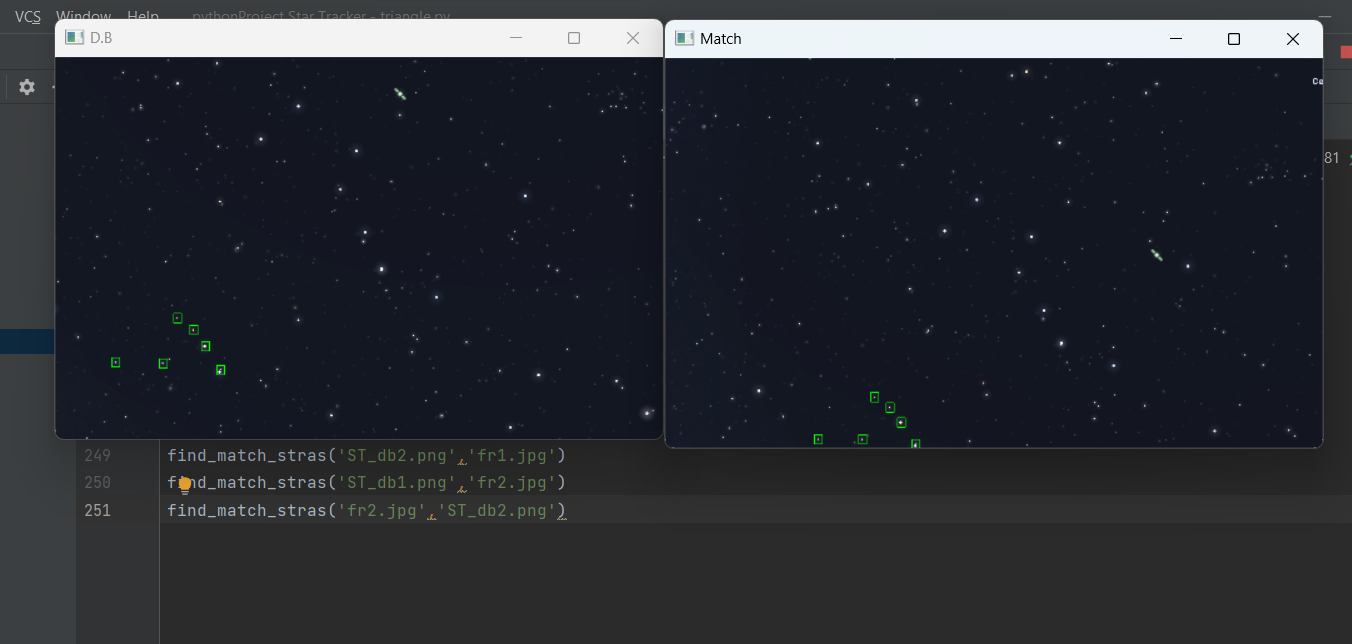

X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 800.3846435546875, Y: 1235.444580078125, Size: 1.0, Response: 0.0


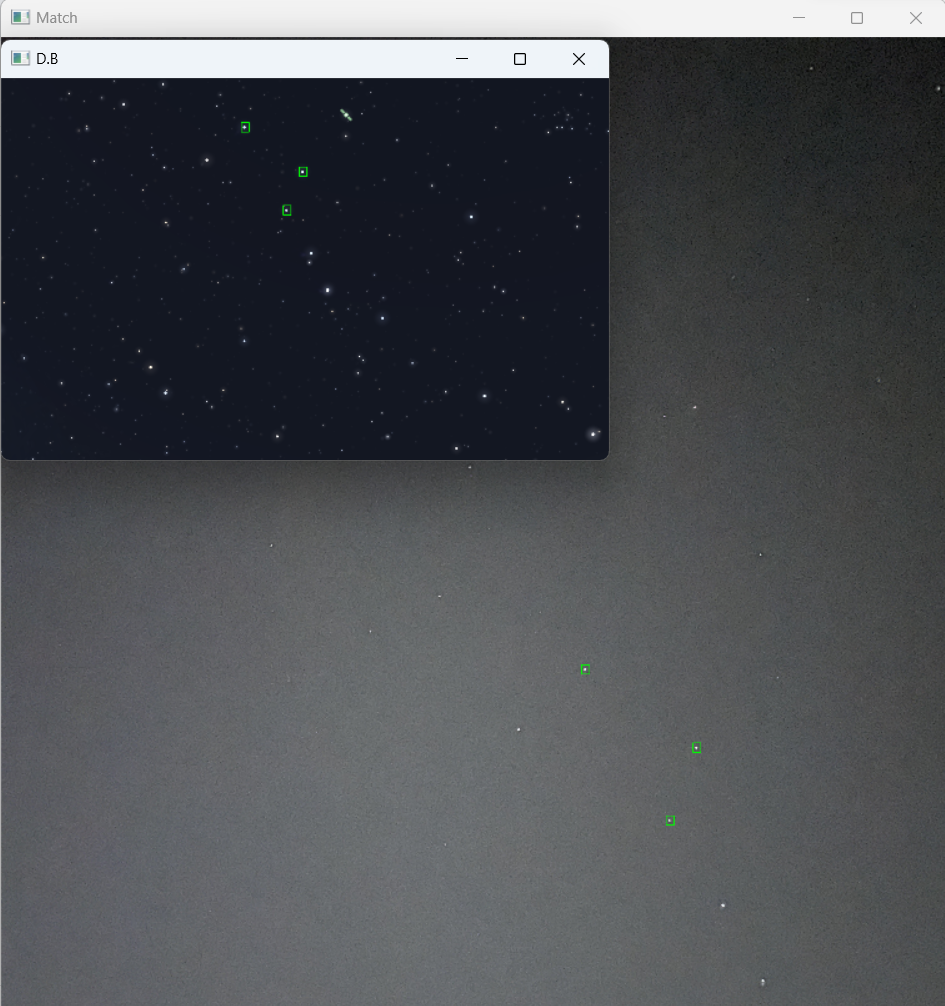

X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 800.3846435546875, Y: 1235.444580078125, Size: 1.0, Response: 0.0
X: 1868.44482421875, Y: 2024.1060791015625, Size: 1.0, Response: 0.0
X: 1868.44482421875, Y: 2024.1060791015625, Size: 1.0, Response: 0.0
X: 1868.44482421875, Y: 2024.1060791015625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2224.8212890625, Y: 2274.4814453125, Size: 1.0, Response: 0.0
X: 2224.8212890625, Y: 2274.4814453125, Size: 1.0, Response: 0.0
X: 2224.8212890625, Y: 2274.4814453125, Size: 1.0, Response: 0.0


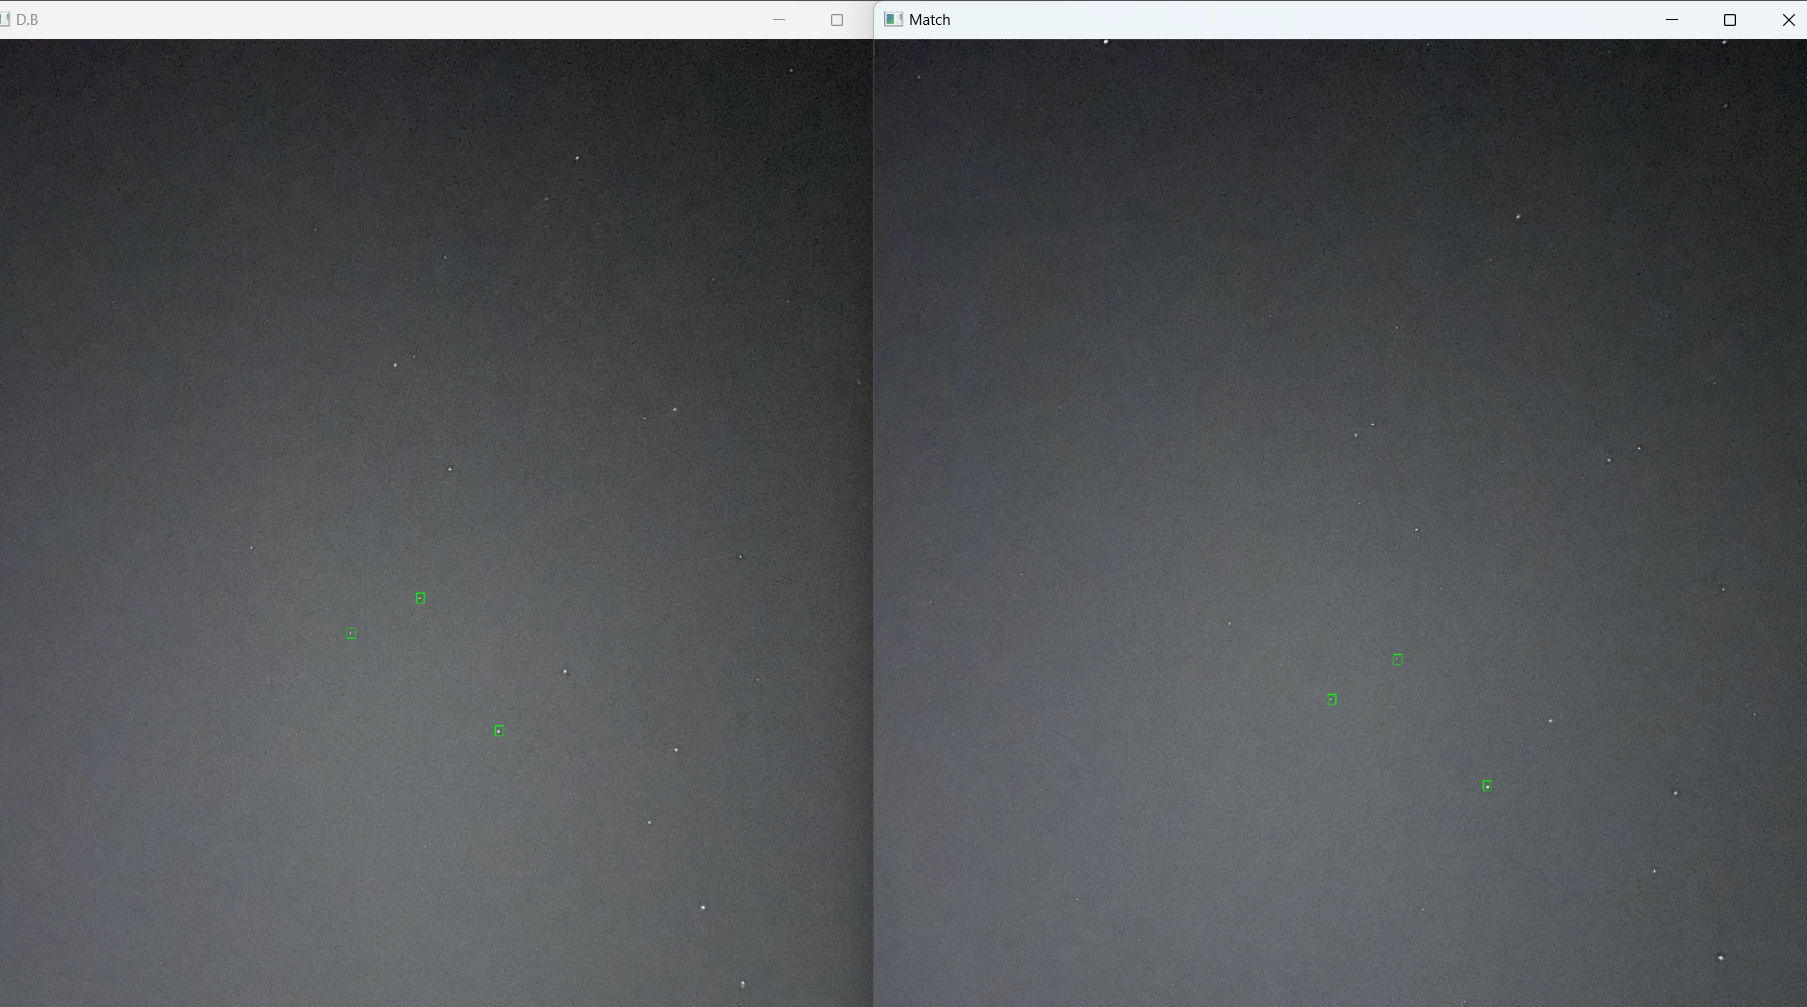

X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 800.3846435546875, Y: 1235.444580078125, Size: 1.0, Response: 0.0


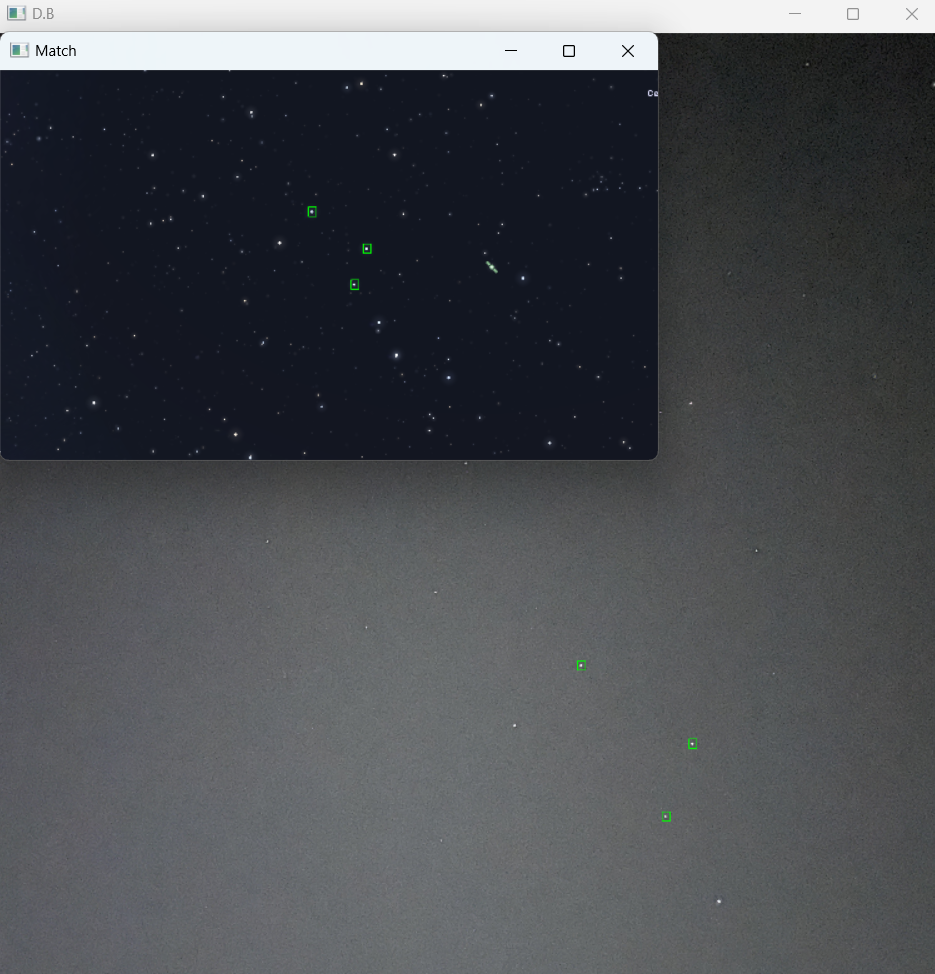

X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 488.8729553222656, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 629.8729248046875, Y: 1220.24609375, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 668.4449462890625, Y: 1085.5721435546875, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 717.321533203125, Y: 1118.988037109375, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 753.0576171875, Y: 1166.131103515625, Size: 1.0, Response: 0.0
X: 800.3846435546875, Y: 1235.444580078125, Size: 1.0, Response: 0.0
X: 1462.16455078125, Y: 2113.41259765625, Size: 1.0, Response: 0.0
X: 1462.16455078125, Y: 2113.41259765625, Size: 1.0, Response: 0.0
X: 1673.873291015625, Y: 1985.8780517578125, Size: 1.0, Response: 0.0
X: 1673.873291015625, Y: 1985.8780517578125, Size: 1.0, Response: 0.0
X: 1960.2376708984375, Y: 2389.995361328125, Size: 1.0, Response: 0.0
X: 1960.2376708984375, Y: 2389.995361328125, Size: 1.0, Response: 0.0
X: 1868.44482421875, Y: 2024.1060791015625, Size: 1.0, Response: 0.0
X: 1868.44482421875, Y: 2024.1060791015625, Size: 1.0, Response: 0.0
X: 1868.44482421875, Y: 2024.1060791015625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2138.58349609375, Y: 2507.845947265625, Size: 1.0, Response: 0.0
X: 2224.8212890625, Y: 2274.4814453125, Size: 1.0, Response: 0.0
X: 2224.8212890625, Y: 2274.4814453125, Size: 1.0, Response: 0.0
X: 2224.8212890625, Y: 2274.4814453125, Size: 1.0, Response: 0.0
X: 996.9913330078125, Y: 453.439697265625, Size: 1.0, Response: 0.0
X: 996.9913330078125, Y: 453.439697265625, Size: 1.0, Response: 0.0
X: 996.9913330078125, Y: 453.439697265625, Size: 1.0, Response: 0.0
X: 996.9913330078125, Y: 453.439697265625, Size: 1.0, Response: 0.0
X: 996.9913330078125, Y: 453.439697265625, Size: 1.0, Response: 0.0
X: 1132.1619873046875, Y: 686.2402954101562, Size: 1.0, Response: 0.0
X: 1132.1619873046875, Y: 686.2402954101562, Size: 1.0, Response: 0.0
X: 1132.1619873046875, Y: 686.2402954101562, Size: 1.0, Response: 0.0
X: 1171.6129150390625, Y: 571.8837280273438, Size: 1.0, Response: 0.0
X: 1171.6129150390625, Y: 571.8837280273438, Size: 1.0, Response: 0.0
X: 1171.6129150390625, Y: 571.8837280273438, Size: 1.0, Response: 0.0

Process finished with exit code 0


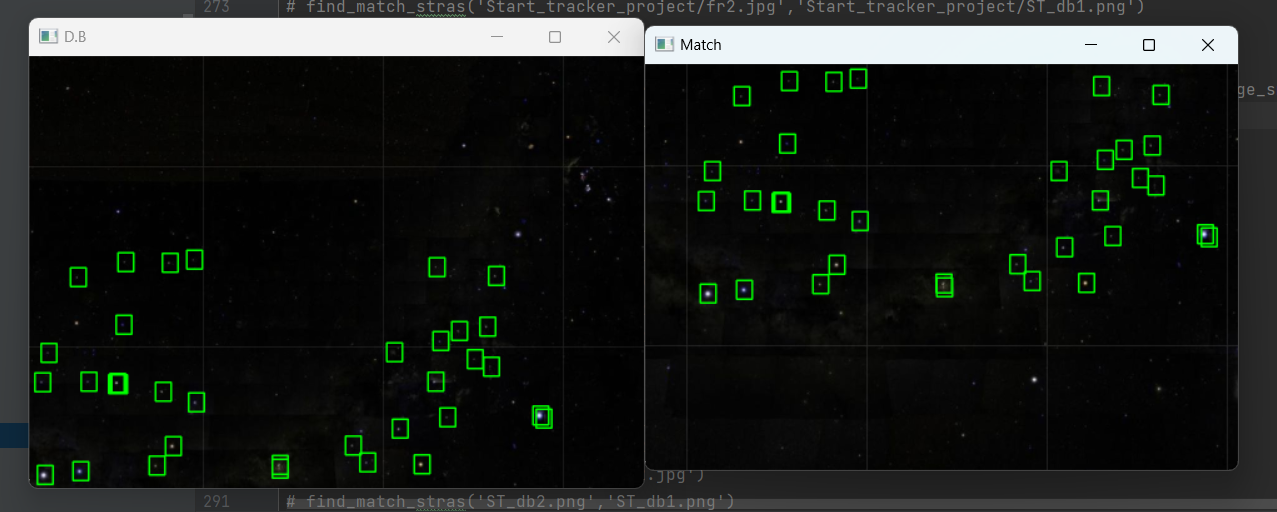

-----Common Points-----

X: 95.27108764648438, Y: 219.11746215820312, Size: 1.0, Response: 0.0
X: 95.27108764648438, Y: 219.11746215820312, Size: 1.0, Response: 0.0
X: 98.82538604736328, Y: 367.6159362792969, Size: 1.0, Response: 0.0
X: 98.82538604736328, Y: 367.6159362792969, Size: 1.0, Response: 0.0
X: 98.82538604736328, Y: 367.6159362792969, Size: 1.0, Response: 0.0
X: 98.82538604736328, Y: 367.6159362792969, Size: 1.0, Response: 0.0
X: 98.82538604736328, Y: 367.6159362792969, Size: 1.0, Response: 0.0
X: 98.82538604736328, Y: 367.6159362792969, Size: 1.0, Response: 0.0
X: 98.82538604736328, Y: 367.6159362792969, Size: 1.0, Response: 0.0
X: 105.36689758300781, Y: 171.96939086914062, Size: 1.0, Response: 0.0
X: 105.36689758300781, Y: 171.96939086914062, Size: 1.0, Response: 0.0
X: 105.36689758300781, Y: 171.96939086914062, Size: 1.0, Response: 0.0
X: 105.36689758300781, Y: 171.96939086914062, Size: 1.0, Response: 0.0
X: 152.07273864746094, Y: 51.38323974609375, Size: 1.0, Response: 0.0
X: 152.07273864746094, Y: 51.38323974609375, Size: 1.0, Response: 0.0
X: 152.07273864746094, Y: 51.38323974609375, Size: 1.0, Response: 0.0
X: 156.3571319580078, Y: 361.5154724121094, Size: 1.0, Response: 0.0
X: 156.3571319580078, Y: 361.5154724121094, Size: 1.0, Response: 0.0
X: 156.3571319580078, Y: 361.5154724121094, Size: 1.0, Response: 0.0
X: 169.5064697265625, Y: 218.27987670898438, Size: 1.0, Response: 0.0
X: 213.51531982421875, Y: 222.12448120117188, Size: 1.0, Response: 0.0
X: 215.7188720703125, Y: 220.06784057617188, Size: 1.0, Response: 0.0
X: 215.7188720703125, Y: 220.06784057617188, Size: 1.0, Response: 0.0
X: 215.7188720703125, Y: 220.06784057617188, Size: 1.0, Response: 0.0
X: 215.7188720703125, Y: 220.06784057617188, Size: 1.0, Response: 0.0
X: 215.7188720703125, Y: 220.06784057617188, Size: 1.0, Response: 0.0
X: 217.99789428710938, Y: 222.52084350585938, Size: 1.0, Response: 0.0
X: 225.34024047851562, Y: 127.16571044921875, Size: 1.0, Response: 0.0
X: 225.34024047851562, Y: 127.16571044921875, Size: 1.0, Response: 0.0
X: 225.34024047851562, Y: 127.16571044921875, Size: 1.0, Response: 0.0
X: 225.34024047851562, Y: 127.16571044921875, Size: 1.0, Response: 0.0
X: 228.33621215820312, Y: 27.114959716796875, Size: 1.0, Response: 0.0
X: 278.33563232421875, Y: 352.8030090332031, Size: 1.0, Response: 0.0
X: 278.33563232421875, Y: 352.8030090332031, Size: 1.0, Response: 0.0
X: 278.33563232421875, Y: 352.8030090332031, Size: 1.0, Response: 0.0
X: 278.33563232421875, Y: 352.8030090332031, Size: 1.0, Response: 0.0
X: 278.33563232421875, Y: 352.8030090332031, Size: 1.0, Response: 0.0
X: 288.3324890136719, Y: 234.19320678710938, Size: 1.0, Response: 0.0
X: 299.78216552734375, Y: 28.51220703125, Size: 1.0, Response: 0.0
X: 304.861083984375, Y: 321.3661804199219, Size: 1.0, Response: 0.0
X: 304.861083984375, Y: 321.3661804199219, Size: 1.0, Response: 0.0
X: 338.4699401855469, Y: 23.452392578125, Size: 1.0, Response: 0.0
X: 338.4699401855469, Y: 23.452392578125, Size: 1.0, Response: 0.0
X: 338.4699401855469, Y: 23.452392578125, Size: 1.0, Response: 0.0
X: 341.4503173828125, Y: 251.53530883789062, Size: 1.0, Response: 0.0
X: 341.4503173828125, Y: 251.53530883789062, Size: 1.0, Response: 0.0
X: 475.8462219238281, Y: 351.8554382324219, Size: 1.0, Response: 0.0
X: 476.4206848144531, Y: 357.5021667480469, Size: 1.0, Response: 0.0
X: 593.311279296875, Y: 320.3824768066406, Size: 1.0, Response: 0.0
X: 593.311279296875, Y: 320.3824768066406, Size: 1.0, Response: 0.0
X: 593.311279296875, Y: 320.3824768066406, Size: 1.0, Response: 0.0
X: 593.311279296875, Y: 320.3824768066406, Size: 1.0, Response: 0.0
X: 593.311279296875, Y: 320.3824768066406, Size: 1.0, Response: 0.0
X: 593.311279296875, Y: 320.3824768066406, Size: 1.0, Response: 0.0
X: 593.311279296875, Y: 320.3824768066406, Size: 1.0, Response: 0.0
X: 616.1056518554688, Y: 347.5351867675781, Size: 1.0, Response: 0.0
X: 659.2176513671875, Y: 171.32308959960938, Size: 1.0, Response: 0.0
X: 659.2176513671875, Y: 171.32308959960938, Size: 1.0, Response: 0.0
X: 659.2176513671875, Y: 171.32308959960938, Size: 1.0, Response: 0.0
X: 668.0787353515625, Y: 293.9439392089844, Size: 1.0, Response: 0.0
X: 668.0787353515625, Y: 293.9439392089844, Size: 1.0, Response: 0.0
X: 668.0787353515625, Y: 293.9439392089844, Size: 1.0, Response: 0.0
X: 668.0787353515625, Y: 293.9439392089844, Size: 1.0, Response: 0.0
X: 703.615478515625, Y: 350.6109924316406, Size: 1.0, Response: 0.0
X: 703.615478515625, Y: 350.6109924316406, Size: 1.0, Response: 0.0
X: 725.1987915039062, Y: 218.37222290039062, Size: 1.0, Response: 0.0
X: 727.3062133789062, Y: 35.2335205078125, Size: 1.0, Response: 0.0
X: 733.873779296875, Y: 153.952392578125, Size: 1.0, Response: 0.0
X: 733.873779296875, Y: 153.952392578125, Size: 1.0, Response: 0.0
X: 733.873779296875, Y: 153.952392578125, Size: 1.0, Response: 0.0
X: 745.0989990234375, Y: 275.5482482910156, Size: 1.0, Response: 0.0
X: 745.0989990234375, Y: 275.5482482910156, Size: 1.0, Response: 0.0
X: 745.0989990234375, Y: 275.5482482910156, Size: 1.0, Response: 0.0
X: 745.0989990234375, Y: 275.5482482910156, Size: 1.0, Response: 0.0
X: 763.2272338867188, Y: 137.45358276367188, Size: 1.0, Response: 0.0
X: 763.2272338867188, Y: 137.45358276367188, Size: 1.0, Response: 0.0
X: 763.2272338867188, Y: 137.45358276367188, Size: 1.0, Response: 0.0
X: 789.0814208984375, Y: 182.18194580078125, Size: 1.0, Response: 0.0
X: 789.0814208984375, Y: 182.18194580078125, Size: 1.0, Response: 0.0
X: 789.0814208984375, Y: 182.18194580078125, Size: 1.0, Response: 0.0
X: 808.481201171875, Y: 130.44046020507812, Size: 1.0, Response: 0.0
X: 814.5995483398438, Y: 194.18099975585938, Size: 1.0, Response: 0.0
X: 814.5995483398438, Y: 194.18099975585938, Size: 1.0, Response: 0.0
X: 822.7205200195312, Y: 49.63653564453125, Size: 1.0, Response: 0.0
X: 893.5930786132812, Y: 272.3909606933594, Size: 1.0, Response: 0.0
X: 893.5930786132812, Y: 272.3909606933594, Size: 1.0, Response: 0.0
X: 899.2876586914062, Y: 277.2176208496094, Size: 1.0, Response: 0.0

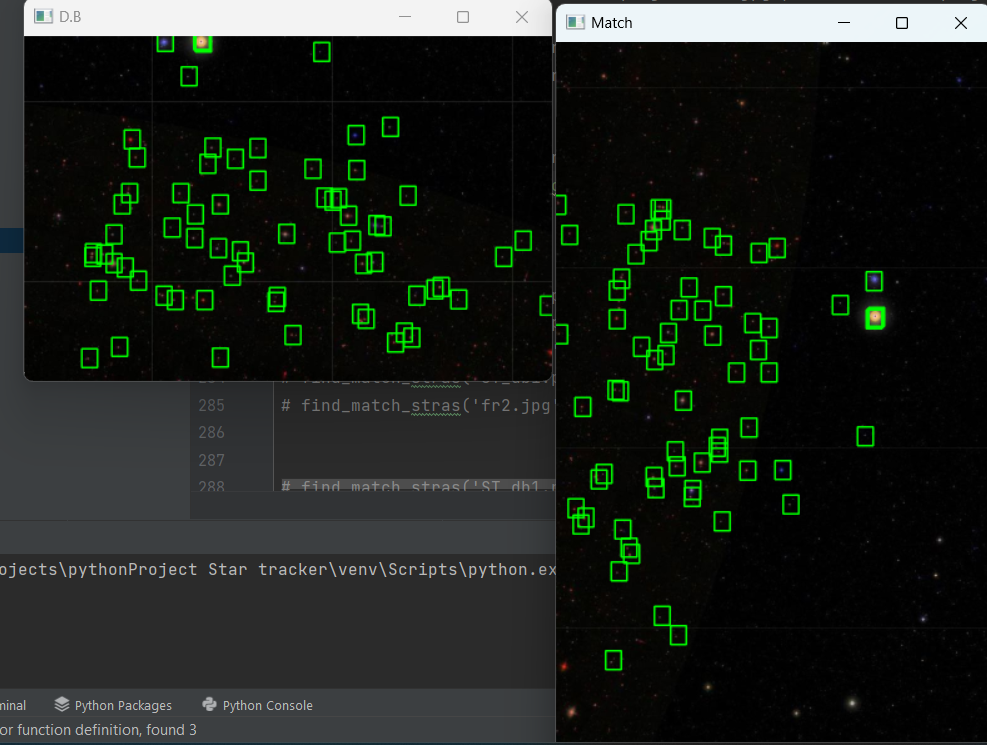

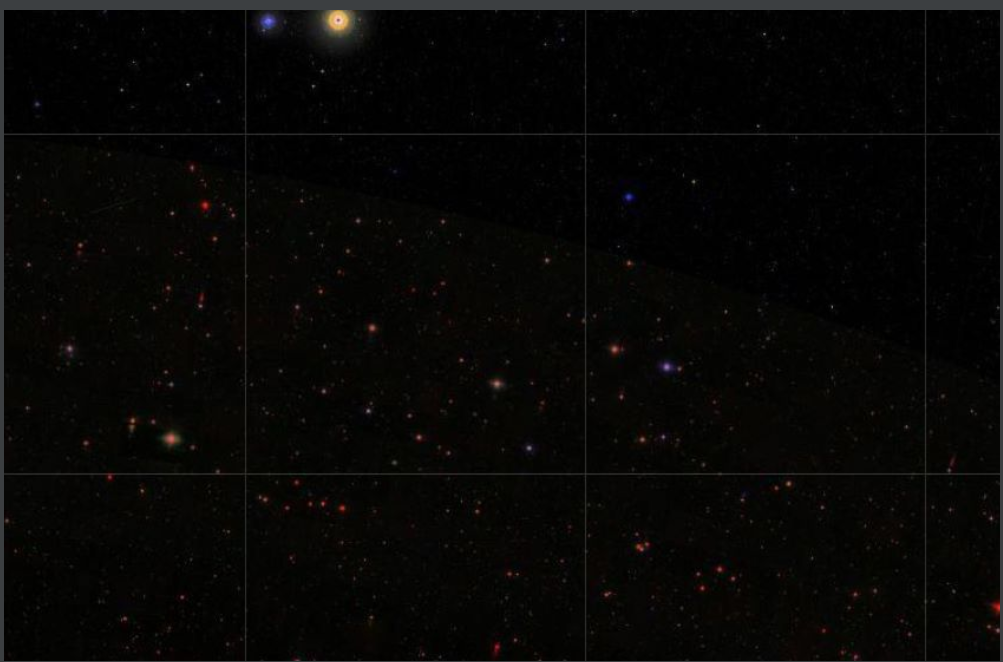


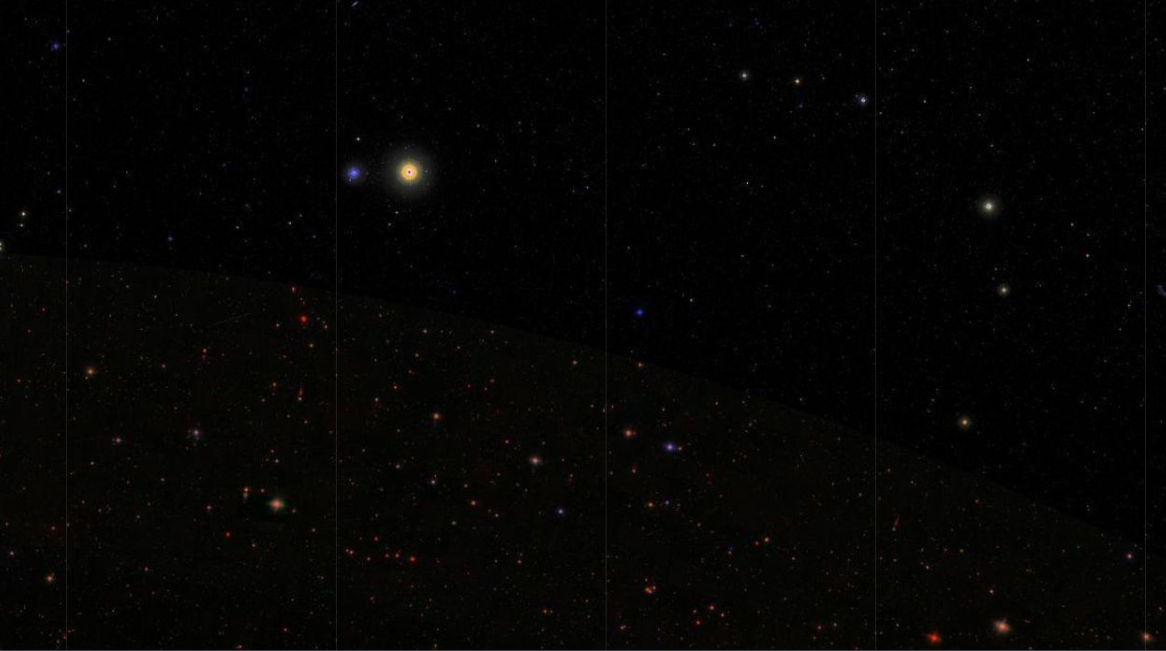

-----Common Points-----

X: 0.80615234375, Y: 260.77496337890625, Size: 1.0, Response: 0.0
X: 0.80615234375, Y: 260.77496337890625, Size: 1.0, Response: 0.0
X: 162.5775146484375, Y: 267.1221618652344, Size: 1.0, Response: 0.0
X: 162.5775146484375, Y: 267.1221618652344, Size: 1.0, Response: 0.0
X: 168.52664184570312, Y: 267.8063049316406, Size: 1.0, Response: 0.0
X: 168.52664184570312, Y: 267.8063049316406, Size: 1.0, Response: 0.0
X: 109.02972412109375, Y: 275.4635314941406, Size: 1.0, Response: 0.0
X: 109.02972412109375, Y: 275.4635314941406, Size: 1.0, Response: 0.0
X: 109.02972412109375, Y: 275.4635314941406, Size: 1.0, Response: 0.0
X: 167.44061279296875, Y: 285.19915771484375, Size: 1.0, Response: 0.0
X: 167.44061279296875, Y: 285.19915771484375, Size: 1.0, Response: 0.0
X: 167.44061279296875, Y: 285.19915771484375, Size: 1.0, Response: 0.0
X: 167.44061279296875, Y: 285.19915771484375, Size: 1.0, Response: 0.0
X: 167.44061279296875, Y: 285.19915771484375, Size: 1.0, Response: 0.0
X: 153.19625854492188, Y: 300.10498046875, Size: 1.0, Response: 0.0
X: 199.31109619140625, Y: 300.2691955566406, Size: 1.0, Response: 0.0
X: 199.31109619140625, Y: 300.2691955566406, Size: 1.0, Response: 0.0
X: 19.257537841796875, Y: 308.78143310546875, Size: 1.0, Response: 0.0
X: 19.257537841796875, Y: 308.78143310546875, Size: 1.0, Response: 0.0
X: 19.257537841796875, Y: 308.78143310546875, Size: 1.0, Response: 0.0
X: 19.257537841796875, Y: 308.78143310546875, Size: 1.0, Response: 0.0
X: 19.257537841796875, Y: 308.78143310546875, Size: 1.0, Response: 0.0
X: 19.257537841796875, Y: 308.78143310546875, Size: 1.0, Response: 0.0
X: 247.34442138671875, Y: 313.22833251953125, Size: 1.0, Response: 0.0
X: 247.34442138671875, Y: 313.22833251953125, Size: 1.0, Response: 0.0
X: 247.34442138671875, Y: 313.22833251953125, Size: 1.0, Response: 0.0
X: 146.0838623046875, Y: 318.0346374511719, Size: 1.0, Response: 0.0
X: 146.0838623046875, Y: 318.0346374511719, Size: 1.0, Response: 0.0
X: 146.0838623046875, Y: 318.0346374511719, Size: 1.0, Response: 0.0
X: 146.0838623046875, Y: 318.0346374511719, Size: 1.0, Response: 0.0
X: 146.0838623046875, Y: 318.0346374511719, Size: 1.0, Response: 0.0
X: 146.0838623046875, Y: 318.0346374511719, Size: 1.0, Response: 0.0
X: 265.530517578125, Y: 325.02642822265625, Size: 1.0, Response: 0.0
X: 265.530517578125, Y: 325.02642822265625, Size: 1.0, Response: 0.0
X: 351.02435302734375, Y: 329.3124694824219, Size: 1.0, Response: 0.0
X: 351.02435302734375, Y: 329.3124694824219, Size: 1.0, Response: 0.0
X: 351.02435302734375, Y: 329.3124694824219, Size: 1.0, Response: 0.0
X: 351.02435302734375, Y: 329.3124694824219, Size: 1.0, Response: 0.0
X: 322.5229797363281, Y: 337.36016845703125, Size: 1.0, Response: 0.0
X: 322.5229797363281, Y: 337.36016845703125, Size: 1.0, Response: 0.0
X: 322.5229797363281, Y: 337.36016845703125, Size: 1.0, Response: 0.0
X: 322.5229797363281, Y: 337.36016845703125, Size: 1.0, Response: 0.0
X: 322.5229797363281, Y: 337.36016845703125, Size: 1.0, Response: 0.0
X: 125.55584716796875, Y: 339.03179931640625, Size: 1.0, Response: 0.0
X: 125.55584716796875, Y: 339.03179931640625, Size: 1.0, Response: 0.0
X: 125.55584716796875, Y: 339.03179931640625, Size: 1.0, Response: 0.0
X: 102.2203369140625, Y: 378.9962158203125, Size: 1.0, Response: 0.0
X: 506.6922302246094, Y: 382.7359313964844, Size: 1.0, Response: 0.0
X: 506.6922302246094, Y: 382.7359313964844, Size: 1.0, Response: 0.0
X: 506.6922302246094, Y: 382.7359313964844, Size: 1.0, Response: 0.0
X: 506.6922302246094, Y: 382.7359313964844, Size: 1.0, Response: 0.0
X: 210.99005126953125, Y: 392.3843078613281, Size: 1.0, Response: 0.0
X: 210.99005126953125, Y: 392.3843078613281, Size: 1.0, Response: 0.0
X: 95.17007446289062, Y: 397.29986572265625, Size: 1.0, Response: 0.0
X: 95.17007446289062, Y: 397.29986572265625, Size: 1.0, Response: 0.0
X: 95.17007446289062, Y: 397.29986572265625, Size: 1.0, Response: 0.0
X: 95.17007446289062, Y: 397.29986572265625, Size: 1.0, Response: 0.0
X: 95.17007446289062, Y: 397.29986572265625, Size: 1.0, Response: 0.0
X: 265.39031982421875, Y: 406.361328125, Size: 1.0, Response: 0.0
X: 265.39031982421875, Y: 406.361328125, Size: 1.0, Response: 0.0
X: 452.52752685546875, Y: 420.3802185058594, Size: 1.0, Response: 0.0
X: 194.16647338867188, Y: 428.16168212890625, Size: 1.0, Response: 0.0
X: 194.16647338867188, Y: 428.16168212890625, Size: 1.0, Response: 0.0
X: 194.16647338867188, Y: 428.16168212890625, Size: 1.0, Response: 0.0
X: 232.25369262695312, Y: 429.234619140625, Size: 1.0, Response: 0.0
X: 510.6659240722656, Y: 439.9624938964844, Size: 1.0, Response: 0.0
X: 508.4303894042969, Y: 441.56793212890625, Size: 1.0, Response: 0.0
X: 508.4303894042969, Y: 441.56793212890625, Size: 1.0, Response: 0.0
X: 508.4303894042969, Y: 441.56793212890625, Size: 1.0, Response: 0.0
X: 506.38323974609375, Y: 443.696533203125, Size: 1.0, Response: 0.0
X: 506.38323974609375, Y: 443.696533203125, Size: 1.0, Response: 0.0
X: 95.43630981445312, Y: 443.521728515625, Size: 1.0, Response: 0.0
X: 312.9915771484375, Y: 449.0643005371094, Size: 1.0, Response: 0.0
X: 338.7266845703125, Y: 457.61328125, Size: 1.0, Response: 0.0
X: 338.7266845703125, Y: 457.61328125, Size: 1.0, Response: 0.0
X: 338.7266845703125, Y: 457.61328125, Size: 1.0, Response: 0.0
X: 177.72616577148438, Y: 465.8394470214844, Size: 1.0, Response: 0.0
X: 177.72616577148438, Y: 465.8394470214844, Size: 1.0, Response: 0.0
X: 177.72616577148438, Y: 465.8394470214844, Size: 1.0, Response: 0.0
X: 3.0806884765625, Y: 467.9311828613281, Size: 1.0, Response: 0.0
X: 3.0806884765625, Y: 467.9311828613281, Size: 1.0, Response: 0.0
X: 248.1015625, Y: 469.1732177734375, Size: 1.0, Response: 0.0
X: 248.1015625, Y: 469.1732177734375, Size: 1.0, Response: 0.0
X: 134.214599609375, Y: 487.522216796875, Size: 1.0, Response: 0.0
X: 321.4413757324219, Y: 492.9521484375, Size: 1.0, Response: 0.0
X: 321.4413757324219, Y: 492.9521484375, Size: 1.0, Response: 0.0
X: 321.4413757324219, Y: 492.9521484375, Size: 1.0, Response: 0.0
X: 321.4413757324219, Y: 492.9521484375, Size: 1.0, Response: 0.0
X: 321.4413757324219, Y: 492.9521484375, Size: 1.0, Response: 0.0
X: 321.4413757324219, Y: 492.9521484375, Size: 1.0, Response: 0.0
X: 173.68106079101562, Y: 500.39764404296875, Size: 1.0, Response: 0.0
X: 173.68106079101562, Y: 500.39764404296875, Size: 1.0, Response: 0.0
X: 155.71090698242188, Y: 508.2141418457031, Size: 1.0, Response: 0.0
X: 155.71090698242188, Y: 508.2141418457031, Size: 1.0, Response: 0.0
X: 155.71090698242188, Y: 508.2141418457031, Size: 1.0, Response: 0.0
X: 155.71090698242188, Y: 508.2141418457031, Size: 1.0, Response: 0.0
X: 155.71090698242188, Y: 508.2141418457031, Size: 1.0, Response: 0.0
X: 155.71090698242188, Y: 508.2141418457031, Size: 1.0, Response: 0.0
X: 338.386474609375, Y: 528.7667236328125, Size: 1.0, Response: 0.0
X: 286.3282165527344, Y: 528.7242431640625, Size: 1.0, Response: 0.0
X: 286.3282165527344, Y: 528.7242431640625, Size: 1.0, Response: 0.0
X: 93.1048583984375, Y: 556.7568359375, Size: 1.0, Response: 0.0
X: 93.1048583984375, Y: 556.7568359375, Size: 1.0, Response: 0.0
X: 100.94461059570312, Y: 558.6730346679688, Size: 1.0, Response: 0.0
X: 201.24716186523438, Y: 573.782470703125, Size: 1.0, Response: 0.0
X: 201.24716186523438, Y: 573.782470703125, Size: 1.0, Response: 0.0
X: 201.24716186523438, Y: 573.782470703125, Size: 1.0, Response: 0.0
X: 40.423980712890625, Y: 583.779296875, Size: 1.0, Response: 0.0
X: 40.423980712890625, Y: 583.779296875, Size: 1.0, Response: 0.0
X: 40.423980712890625, Y: 583.779296875, Size: 1.0, Response: 0.0
X: 40.423980712890625, Y: 583.779296875, Size: 1.0, Response: 0.0
X: 40.423980712890625, Y: 583.779296875, Size: 1.0, Response: 0.0
X: 40.423980712890625, Y: 583.779296875, Size: 1.0, Response: 0.0
X: 306.09295654296875, Y: 616.15771484375, Size: 1.0, Response: 0.0
X: 306.09295654296875, Y: 616.15771484375, Size: 1.0, Response: 0.0
X: 492.87982177734375, Y: 630.2758178710938, Size: 1.0, Response: 0.0
X: 492.87982177734375, Y: 630.2758178710938, Size: 1.0, Response: 0.0
X: 259.86505126953125, Y: 634.2392578125, Size: 1.0, Response: 0.0
X: 259.86505126953125, Y: 634.2392578125, Size: 1.0, Response: 0.0
X: 259.86505126953125, Y: 634.2392578125, Size: 1.0, Response: 0.0
X: 255.3480224609375, Y: 647.0905151367188, Size: 1.0, Response: 0.0
X: 188.45123291015625, Y: 654.1744384765625, Size: 1.0, Response: 0.0
X: 259.37213134765625, Y: 656.1502685546875, Size: 1.0, Response: 0.0
X: 259.37213134765625, Y: 656.1502685546875, Size: 1.0, Response: 0.0
X: 231.17138671875, Y: 672.6446533203125, Size: 1.0, Response: 0.0
X: 231.17138671875, Y: 672.6446533203125, Size: 1.0, Response: 0.0
X: 231.17138671875, Y: 672.6446533203125, Size: 1.0, Response: 0.0
X: 231.17138671875, Y: 672.6446533203125, Size: 1.0, Response: 0.0
X: 231.17138671875, Y: 672.6446533203125, Size: 1.0, Response: 0.0
X: 191.128173828125, Y: 678.13037109375, Size: 1.0, Response: 0.0
X: 191.128173828125, Y: 678.13037109375, Size: 1.0, Response: 0.0
X: 191.128173828125, Y: 678.13037109375, Size: 1.0, Response: 0.0
X: 360.10302734375, Y: 684.9518432617188, Size: 1.0, Response: 0.0
X: 360.10302734375, Y: 684.9518432617188, Size: 1.0, Response: 0.0
X: 304.58050537109375, Y: 685.103515625, Size: 1.0, Response: 0.0
X: 304.58050537109375, Y: 685.103515625, Size: 1.0, Response: 0.0
X: 74.89849853515625, Y: 690.7435913085938, Size: 1.0, Response: 0.0
X: 154.93304443359375, Y: 695.7345581054688, Size: 1.0, Response: 0.0
X: 154.93304443359375, Y: 695.7345581054688, Size: 1.0, Response: 0.0
X: 154.93304443359375, Y: 695.7345581054688, Size: 1.0, Response: 0.0
X: 66.38177490234375, Y: 699.4117431640625, Size: 1.0, Response: 0.0
X: 66.38177490234375, Y: 699.4117431640625, Size: 1.0, Response: 0.0
X: 157.23477172851562, Y: 713.3641967773438, Size: 1.0, Response: 0.0
X: 157.23477172851562, Y: 713.3641967773438, Size: 1.0, Response: 0.0
X: 157.23477172851562, Y: 713.3641967773438, Size: 1.0, Response: 0.0
X: 157.23477172851562, Y: 713.3641967773438, Size: 1.0, Response: 0.0
X: 216.474365234375, Y: 716.40673828125, Size: 1.0, Response: 0.0
X: 216.474365234375, Y: 716.40673828125, Size: 1.0, Response: 0.0
X: 215.07217407226562, Y: 727.1498413085938, Size: 1.0, Response: 0.0
X: 215.07217407226562, Y: 727.1498413085938, Size: 1.0, Response: 0.0
X: 215.07217407226562, Y: 727.1498413085938, Size: 1.0, Response: 0.0
X: 373.45892333984375, Y: 739.4243774414062, Size: 1.0, Response: 0.0
X: 373.45892333984375, Y: 739.4243774414062, Size: 1.0, Response: 0.0
X: 373.45892333984375, Y: 739.4243774414062, Size: 1.0, Response: 0.0
X: 373.45892333984375, Y: 739.4243774414062, Size: 1.0, Response: 0.0
X: 373.45892333984375, Y: 739.4243774414062, Size: 1.0, Response: 0.0
X: 29.448394775390625, Y: 745.7120361328125, Size: 1.0, Response: 0.0
X: 29.448394775390625, Y: 745.7120361328125, Size: 1.0, Response: 0.0
X: 45.4808349609375, Y: 760.3284301757812, Size: 1.0, Response: 0.0
X: 45.4808349609375, Y: 760.3284301757812, Size: 1.0, Response: 0.0
X: 45.4808349609375, Y: 760.3284301757812, Size: 1.0, Response: 0.0
X: 45.4808349609375, Y: 760.3284301757812, Size: 1.0, Response: 0.0
X: 45.4808349609375, Y: 760.3284301757812, Size: 1.0, Response: 0.0
X: 45.4808349609375, Y: 760.3284301757812, Size: 1.0, Response: 0.0
X: 263.73388671875, Y: 766.2869262695312, Size: 1.0, Response: 0.0
X: 263.73388671875, Y: 766.2869262695312, Size: 1.0, Response: 0.0
X: 263.73388671875, Y: 766.2869262695312, Size: 1.0, Response: 0.0
X: 263.73388671875, Y: 766.2869262695312, Size: 1.0, Response: 0.0
X: 37.57672119140625, Y: 771.5365600585938, Size: 1.0, Response: 0.0
X: 104.30325317382812, Y: 779.5808715820312, Size: 1.0, Response: 0.0
X: 104.30325317382812, Y: 779.5808715820312, Size: 1.0, Response: 0.0
X: 104.30325317382812, Y: 779.5808715820312, Size: 1.0, Response: 0.0
X: 114.614990234375, Y: 808.3010864257812, Size: 1.0, Response: 0.0
X: 114.614990234375, Y: 808.3010864257812, Size: 1.0, Response: 0.0
X: 114.614990234375, Y: 808.3010864257812, Size: 1.0, Response: 0.0
X: 114.614990234375, Y: 808.3010864257812, Size: 1.0, Response: 0.0
X: 118.32965087890625, Y: 818.3328247070312, Size: 1.0, Response: 0.0
X: 118.32965087890625, Y: 818.3328247070312, Size: 1.0, Response: 0.0
X: 98.54281616210938, Y: 846.7015380859375, Size: 1.0, Response: 0.0
X: 98.54281616210938, Y: 846.7015380859375, Size: 1.0, Response: 0.0
X: 98.54281616210938, Y: 846.7015380859375, Size: 1.0, Response: 0.0
X: 98.54281616210938, Y: 846.7015380859375, Size: 1.0, Response: 0.0
X: 167.0982666015625, Y: 917.457275390625, Size: 1.0, Response: 0.0
X: 167.0982666015625, Y: 917.457275390625, Size: 1.0, Response: 0.0
X: 167.0982666015625, Y: 917.457275390625, Size: 1.0, Response: 0.0
X: 193.1766357421875, Y: 948.2542114257812, Size: 1.0, Response: 0.0
X: 193.1766357421875, Y: 948.2542114257812, Size: 1.0, Response: 0.0
X: 193.1766357421875, Y: 948.2542114257812, Size: 1.0, Response: 0.0
X: 89.76348876953125, Y: 988.260498046875, Size: 1.0, Response: 0.0
X: 89.76348876953125, Y: 988.260498046875, Size: 1.0, Response: 0.0
X: 89.76348876953125, Y: 988.260498046875, Size: 1.0, Response: 0.0

Process finished with exit code 0


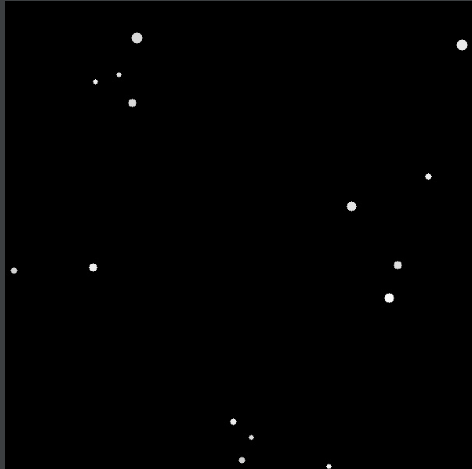

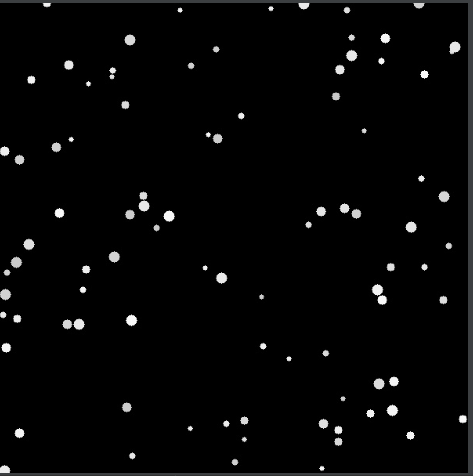

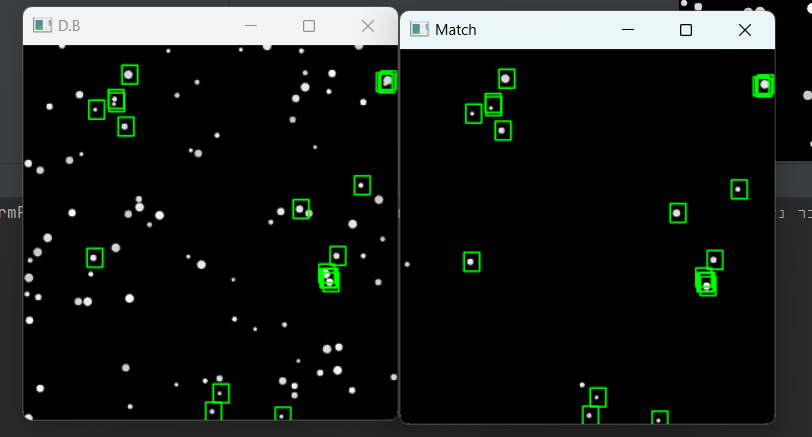


-----Common Points-----

X: 112.24397277832031, Y: 340.25372314453125, Size: 1.0, Response: 0.0
X: 112.24397277832031, Y: 340.25372314453125, Size: 1.0, Response: 0.0
X: 112.24397277832031, Y: 340.25372314453125, Size: 1.0, Response: 0.0
X: 112.24397277832031, Y: 340.25372314453125, Size: 1.0, Response: 0.0
X: 112.24397277832031, Y: 340.25372314453125, Size: 1.0, Response: 0.0
X: 112.24397277832031, Y: 340.25372314453125, Size: 1.0, Response: 0.0
X: 115.25030517578125, Y: 103.24712371826172, Size: 1.0, Response: 0.0
X: 115.25030517578125, Y: 103.24712371826172, Size: 1.0, Response: 0.0
X: 115.25030517578125, Y: 103.24712371826172, Size: 1.0, Response: 0.0
X: 115.25030517578125, Y: 103.24712371826172, Size: 1.0, Response: 0.0
X: 146.33489990234375, Y: 86.03473663330078, Size: 1.0, Response: 0.0
X: 146.33489990234375, Y: 86.03473663330078, Size: 1.0, Response: 0.0
X: 147.4808349609375, Y: 91.24191284179688, Size: 1.0, Response: 0.0
X: 162.2486572265625, Y: 130.2436981201172, Size: 1.0, Response: 0.0
X: 162.2486572265625, Y: 130.2436981201172, Size: 1.0, Response: 0.0
X: 162.2486572265625, Y: 130.2436981201172, Size: 1.0, Response: 0.0
X: 162.2486572265625, Y: 130.2436981201172, Size: 1.0, Response: 0.0
X: 162.2486572265625, Y: 130.2436981201172, Size: 1.0, Response: 0.0
X: 162.2486572265625, Y: 130.2436981201172, Size: 1.0, Response: 0.0
X: 168.2432861328125, Y: 47.25376510620117, Size: 1.0, Response: 0.0
X: 168.2432861328125, Y: 47.25376510620117, Size: 1.0, Response: 0.0
X: 168.2432861328125, Y: 47.25376510620117, Size: 1.0, Response: 0.0
X: 168.2432861328125, Y: 47.25376510620117, Size: 1.0, Response: 0.0
X: 168.2432861328125, Y: 47.25376510620117, Size: 1.0, Response: 0.0
X: 168.2432861328125, Y: 47.25376510620117, Size: 1.0, Response: 0.0
X: 168.2432861328125, Y: 47.25376510620117, Size: 1.0, Response: 0.0
X: 168.2432861328125, Y: 47.25376510620117, Size: 1.0, Response: 0.0
X: 302.2557067871094, Y: 586.249755859375, Size: 1.0, Response: 0.0
X: 302.2557067871094, Y: 586.249755859375, Size: 1.0, Response: 0.0
X: 302.2557067871094, Y: 586.249755859375, Size: 1.0, Response: 0.0
X: 302.2557067871094, Y: 586.249755859375, Size: 1.0, Response: 0.0
X: 302.2557067871094, Y: 586.249755859375, Size: 1.0, Response: 0.0
X: 314.2408447265625, Y: 557.24072265625, Size: 1.0, Response: 0.0
X: 314.2408447265625, Y: 557.24072265625, Size: 1.0, Response: 0.0
X: 314.2408447265625, Y: 557.24072265625, Size: 1.0, Response: 0.0
X: 314.2408447265625, Y: 557.24072265625, Size: 1.0, Response: 0.0
X: 314.2408447265625, Y: 557.24072265625, Size: 1.0, Response: 0.0
X: 314.2408447265625, Y: 557.24072265625, Size: 1.0, Response: 0.0
X: 413.2445373535156, Y: 594.218505859375, Size: 1.0, Response: 0.0
X: 413.2445373535156, Y: 594.218505859375, Size: 1.0, Response: 0.0
X: 413.2445373535156, Y: 594.218505859375, Size: 1.0, Response: 0.0
X: 413.2445373535156, Y: 594.218505859375, Size: 1.0, Response: 0.0
X: 413.2445373535156, Y: 594.218505859375, Size: 1.0, Response: 0.0
X: 413.2445373535156, Y: 594.218505859375, Size: 1.0, Response: 0.0
X: 442.02886962890625, Y: 262.1793518066406, Size: 1.0, Response: 0.0
X: 442.02886962890625, Y: 262.1793518066406, Size: 1.0, Response: 0.0
X: 442.02886962890625, Y: 262.1793518066406, Size: 1.0, Response: 0.0
X: 442.02886962890625, Y: 262.1793518066406, Size: 1.0, Response: 0.0
X: 442.02886962890625, Y: 262.1793518066406, Size: 1.0, Response: 0.0
X: 442.02886962890625, Y: 262.1793518066406, Size: 1.0, Response: 0.0
X: 483.9786682128906, Y: 365.7196044921875, Size: 1.0, Response: 0.0
X: 483.9786682128906, Y: 365.7196044921875, Size: 1.0, Response: 0.0
X: 485.9471740722656, Y: 373.6595764160156, Size: 1.0, Response: 0.0
X: 485.9471740722656, Y: 373.6595764160156, Size: 1.0, Response: 0.0
X: 488.56219482421875, Y: 372.852783203125, Size: 1.0, Response: 0.0
X: 488.56219482421875, Y: 372.852783203125, Size: 1.0, Response: 0.0
X: 490.5126953125, Y: 379.7622985839844, Size: 1.0, Response: 0.0
X: 490.5126953125, Y: 379.7622985839844, Size: 1.0, Response: 0.0
X: 501.1988830566406, Y: 337.19439697265625, Size: 1.0, Response: 0.0
X: 501.1988830566406, Y: 337.19439697265625, Size: 1.0, Response: 0.0
X: 540.252197265625, Y: 224.2386016845703, Size: 1.0, Response: 0.0
X: 540.252197265625, Y: 224.2386016845703, Size: 1.0, Response: 0.0
X: 540.252197265625, Y: 224.2386016845703, Size: 1.0, Response: 0.0
X: 540.252197265625, Y: 224.2386016845703, Size: 1.0, Response: 0.0
X: 540.252197265625, Y: 224.2386016845703, Size: 1.0, Response: 0.0
X: 575.1825561523438, Y: 59.16915512084961, Size: 1.0, Response: 0.0
X: 579.430419921875, Y: 61.54391860961914, Size: 1.0, Response: 0.0
X: 579.430419921875, Y: 61.54391860961914, Size: 1.0, Response: 0.0
X: 582.9824829101562, Y: 56.69371032714844, Size: 1.0, Response: 0.0

Process finished with exit code 0
